# Part 1: Import Data and EDA

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from google.colab import drive


from math import sqrt
from sklearn.metrics import mean_squared_error

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

In [ ]:
#load the data
drive.mount('/gdrive', force_remount=True)
# To set the path
%cd '/gdrive/MyDrive/test/Inventory Demand Forecasting/Data/'
sample = pd.read_csv('sample_submission.csv')
train = pd.read_csv('train.csv',parse_dates=['date'])
test = pd.read_csv('test.csv',parse_dates=['date'])

Mounted at /gdrive
/gdrive/MyDrive/test/Inventory Demand Forecasting/Data


In [ ]:
print("Train and Test shape are {} and {} respectively".format(train.shape,test.shape))

Train and Test shape are (913000, 4) and (45000, 4) respectively


In [ ]:
print("Min date from train set: {}".format(train.date.min()))
print("Max date from train set: {}".format(train.date.max()))
print("Min date from test set: {}".format(test.date.min()))
print("Max date from test set: {}".format(test.date.max()))

Min date from train set: 2013-01-01 00:00:00
Max date from train set: 2017-12-31 00:00:00
Min date from test set: 2018-01-01 00:00:00
Max date from test set: 2018-03-31 00:00:00


forecast period is 3 months. There are 10 stores and 50 items. 500 combinations of stores and items.

## Overall daily sales

In [ ]:
daily_sales = train.groupby('date', as_index=False)['sales'].sum()
daily_sales_sc = go.Scatter(x = daily_sales['date'], y = daily_sales['sales'])
fig = go.Figure(data = daily_sales_sc)
iplot(fig)

Yearly pattern with larger scale near July and lower volume near beginning of years and uptrend is shown.

# Overall weekly sales

In [ ]:
train['weekday'] = train['date'].dt.weekday
week_sales = train.groupby('weekday', as_index = False).sales.mean()
week_sales_sc = go.Scatter(x = week_sales['weekday'], y = week_sales['sales'])
fig = go.Figure(data = week_sales_sc)
iplot(fig)

Saturday and Sunday showing larger sales than weekdays.

## Daily Sales by Store

In [ ]:
store_sales = train.groupby(['date','store'], as_index = False)['sales'].sum()
store_sales_sc = []
for store in store_sales.store.unique():
    current_store = store_sales[(store_sales['store'] == store)]
    store_sales_sc.append(go.Scatter(x = current_store['date'], y = current_store['sales'],
                                    name = ('store %s' % store)))
fig = go.Figure(data = store_sales_sc)
iplot(fig)

Seasonality and trend for each store are similar

## Daily sales by item

In [ ]:
item_sales = train.groupby(['date','item'], as_index = False)['sales'].sum()
item_sales_sc = []
for item in item_sales['item'].unique():
    current_item = item_sales[item_sales['item'] == item]
    item_sales_sc.append(go.Scatter(x = current_item['date'], y = current_item['sales'],
                                   name = 'item %s' % item))
fig = go.Figure(data = item_sales_sc)
iplot(fig)

Seasonality and trend for each item are similar

# Part 2: ARIMA, SARIMA, SARIMAX

## Method 1: auto.arima find p, d, q

In [ ]:
#As store and item following similar patterns, take store 1 and item 1 to study the time series parameters
train_1 = train[(train['store']==1) & (train['item'] == 1)]

In [ ]:
train_1_df = train_1[:(len(train_1)-90)]
valid_1_df = train_1[len(train_1)-90:len(train_1)]

train_1_df.drop(columns = ['store','item','weekday'], inplace=True)
valid_1_df.drop(columns = ['store','item','weekday'], inplace=True)

train_1_df = train_1_df.set_index('date')
valid_1_df = valid_1_df.set_index('date')

In [ ]:
#built the model
!pip install pmdarima
from pmdarima import auto_arima

stepwise_model = auto_arima(train_1_df,m=7,
                           seasonal=True,
                           trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.5 MB/s eta 0:00:00
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=7.55 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=11714.056, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=11220.585, Time=0.67 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=10674.023, Time=1.31 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=11712.056, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=10779.593, Time=0.92 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=6.20 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=10602.136, Time=2.14 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=12.78 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=11562.519, Time=1.16 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=10595.438, Time=2.73 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=10667.359, Time=1.33 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=12.87 sec
 ARIMA(1,1,1)(1,0,1)[7] interc

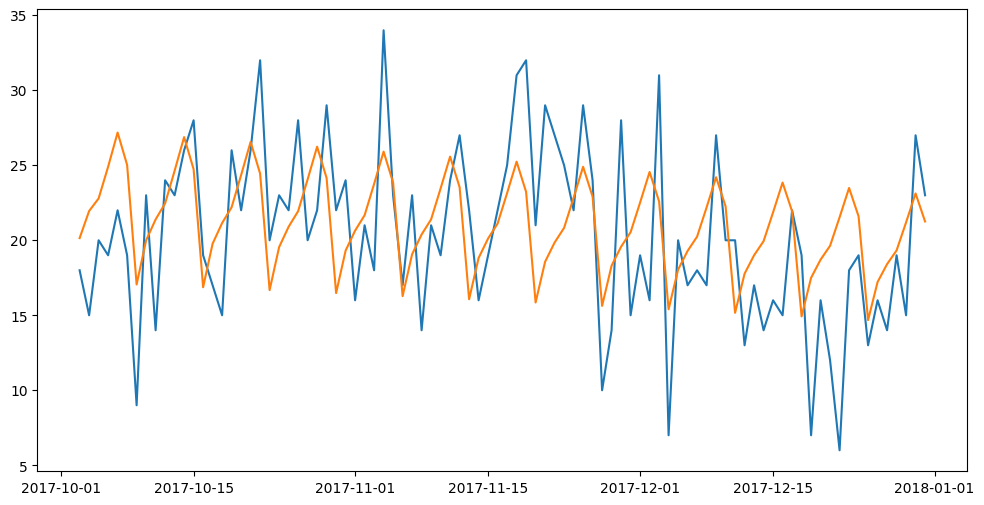

In [ ]:
stepwise_model.fit(train_1_df)
forecast_stp = stepwise_model.predict(n_periods=len(valid_1_df))
forecast_stp = pd.DataFrame(forecast_stp, index = valid_1_df.index, columns=['Prediction'])

fig, ax = plt.subplots(figsize=(12,6))
# plt.plot(train_1_df, label='Train')
plt.plot(valid_1_df, label='Valid')
plt.plot(forecast_stp, label='Prediction')
plt.show()

In [ ]:
#calculate mse, mape, smape
mse1 = "{:.2%}".format(sqrt(mean_squared_error(valid_1_df,forecast_stp))/100)
y_true = valid_1_df.sales
y_pred = forecast_stp.Prediction
mape1 ="{:.2%}".format(np.mean(abs((y_true-y_pred)/y_true)))
smape1 = "{:.2%}".format(np.mean((np.abs(y_pred - y_true) * 2/ (np.abs(y_pred) + np.abs(y_true))).fillna(0)))

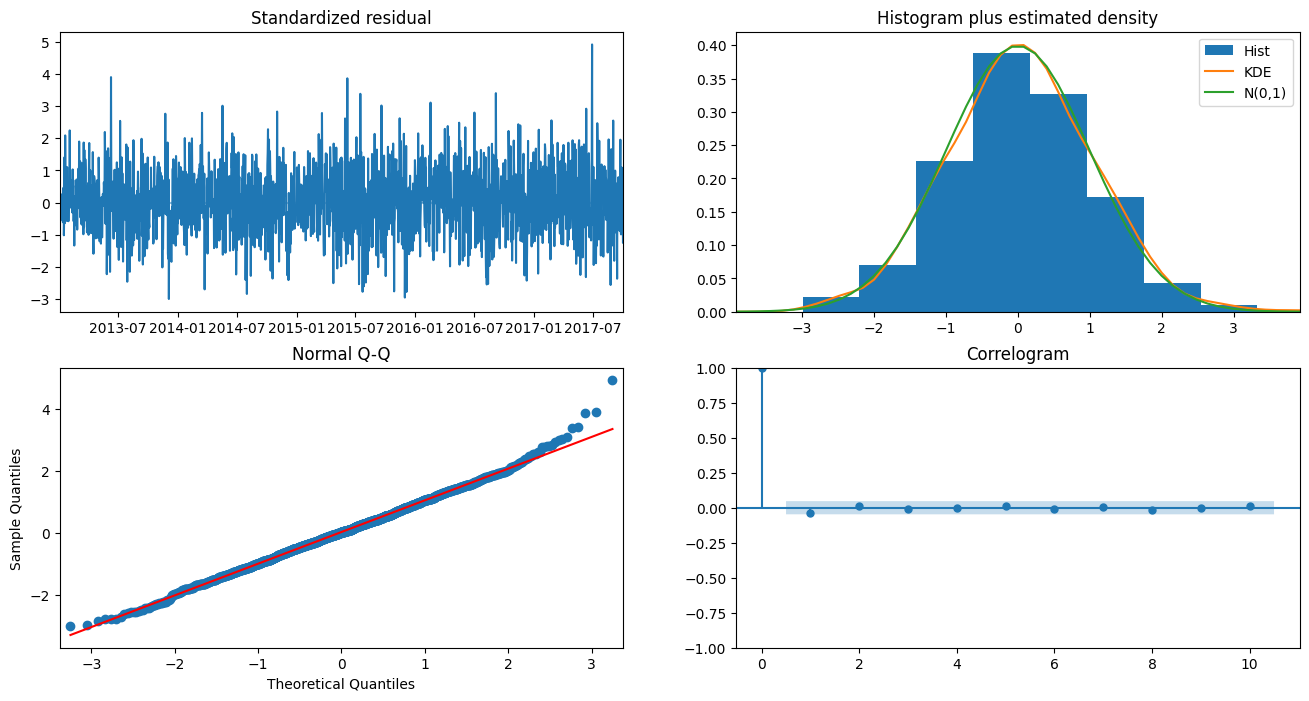

In [ ]:
stepwise_model.plot_diagnostics(figsize=(16, 8))
plt.show()

Residuals following in Normal and no correlation.

In [ ]:
model_eval = pd.DataFrame(data = np.array([['(3,1,1)(1,0,1)[7]',10335.10,mse1,mape1,smape1,'Pass']]),
                         columns = ['model','AIC','MSE','MAPE','MAPE','Residual Test'])
model_eval = model_eval.set_index('model')
model_eval

,AIC,MSE,MAPE,MAPE,Residual Test
model,,,,,
"(3,1,1)(1,0,1)[7]",10335.1,5.14%,26.69%,22.42%,Pass


## Method 2: ACF and PACF results determine p, d, q

In [ ]:
train_1 = train_1.set_index('date')
train_1.head()

,store,item,sales,weekday
date,,,,
2013-01-01,1,1,13,1
2013-01-02,1,1,11,2
2013-01-03,1,1,14,3
2013-01-04,1,1,13,4
2013-01-05,1,1,10,5


### a. stationarity check

In [ ]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):
    #Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)

    print(dfoutput)

In [ ]:
test_stationarity(train_1['sales'])

Results of Dickey-Fuller Test:
p-value = 0.0361. The series is likely non-stationary.
Test Statistic                   -2.987278
p-value                           0.036100
#Lags Used                       20.000000
Number of Observations Used    1805.000000
Critical Value (1%)              -3.433978
Critical Value (5%)              -2.863143
Critical Value (10%)             -2.567623
dtype: float64


Differencing is needed for this time series

### b. Differencing

In [ ]:
first_diff = train_1.sales - train_1.sales.shift(1)
first_diff = first_diff.dropna(inplace = False)
test_stationarity(first_diff)

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.520810e+01
p-value                        5.705031e-28
#Lags Used                     2.000000e+01
Number of Observations Used    1.804000e+03
Critical Value (1%)           -3.433980e+00
Critical Value (5%)           -2.863143e+00
Critical Value (10%)          -2.567624e+00
dtype: float64


Differencing once is good enough to stationarize the time serise.

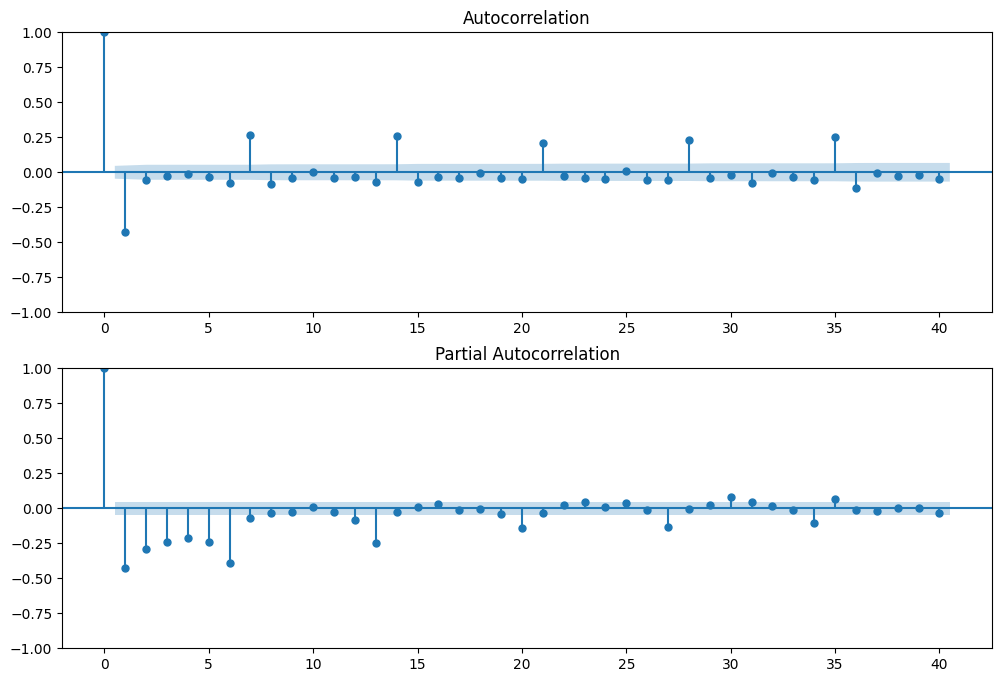

In [ ]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(first_diff, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(first_diff, lags=40, ax=ax2)

Here we can see the acf and pacf both has a recurring pattern every 7 periods. Indicating a weekly pattern exists.

1. AR lags significant at 6.
2. Spike at lag 7,14,21,28,35.. in the ACF
   Exponential decay in the seasonal lags of the PACF (i.e., at lags 7, 14, …).
   Suggested seasonal order of (0,1,1,7)

In [ ]:
train_1 = train[(train['store']==1)&(train['item']==1)]
train_1 = train_1.set_index('date')
start_index = '2017-10-01'
end_index = '2017-12-31'
end_index1 = '2017-12-30'

sarima_mod7 = sm.tsa.statespace.SARIMAX(endog = train_1.sales[:start_index],
                                         order=(7,1,0),
                                         seasonal_order=(0,1,1,7),
                                         freq='D').fit()

train_1['forecast'] = sarima_mod7.predict(start = pd.to_datetime(start_index),
                                           end= pd.to_datetime(end_index),
                                           dynamic= True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



<Axes: xlabel='date'>

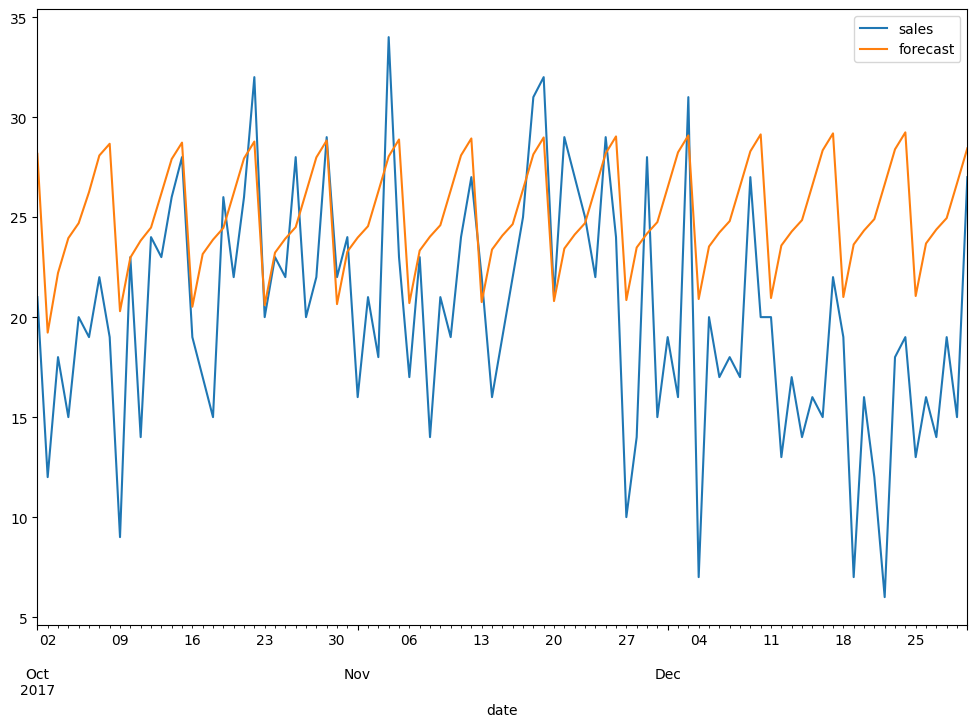

In [ ]:
train_1[start_index:end_index1][['sales', 'forecast']].plot(figsize=(12, 8))

In [ ]:
#calculate mse, mape, smape
mse2 = "{:.2%}".format(sqrt(mean_squared_error(train_1[start_index:end_index]['sales'],
                                                             train_1[start_index:end_index]['forecast']))/100)
y_true = train_1[start_index:end_index1]['sales']
y_pred = train_1[start_index:end_index1]['forecast']

mape2 ="{:.2%}".format(np.mean(abs((y_true-y_pred)/y_true)))
smape2 = "{:.2%}".format(np.mean((np.abs(y_pred - y_true) * 2/ (np.abs(y_pred) + np.abs(y_true))).fillna(0)))

In [ ]:
mse = sqrt(mean_squared_error(train_1[start_index:end_index]['sales'],
                                                             train_1[start_index:end_index]['forecast']))
print('MSE: %.2f %% \nAIC: %.2f'% (mse,sarima_mod7.aic))

MSE: 7.17 % 
AIC: 10328.64


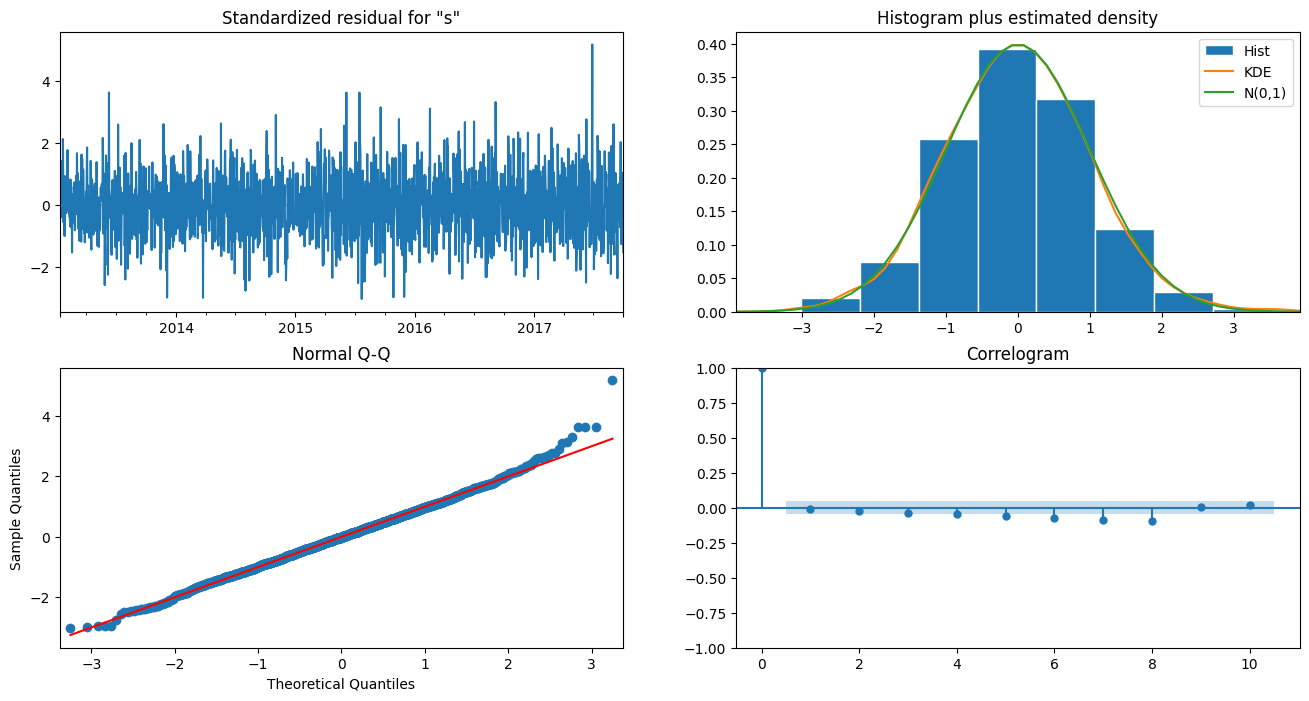

In [ ]:
sarima_mod7.plot_diagnostics(figsize=(16, 8))
plt.show()

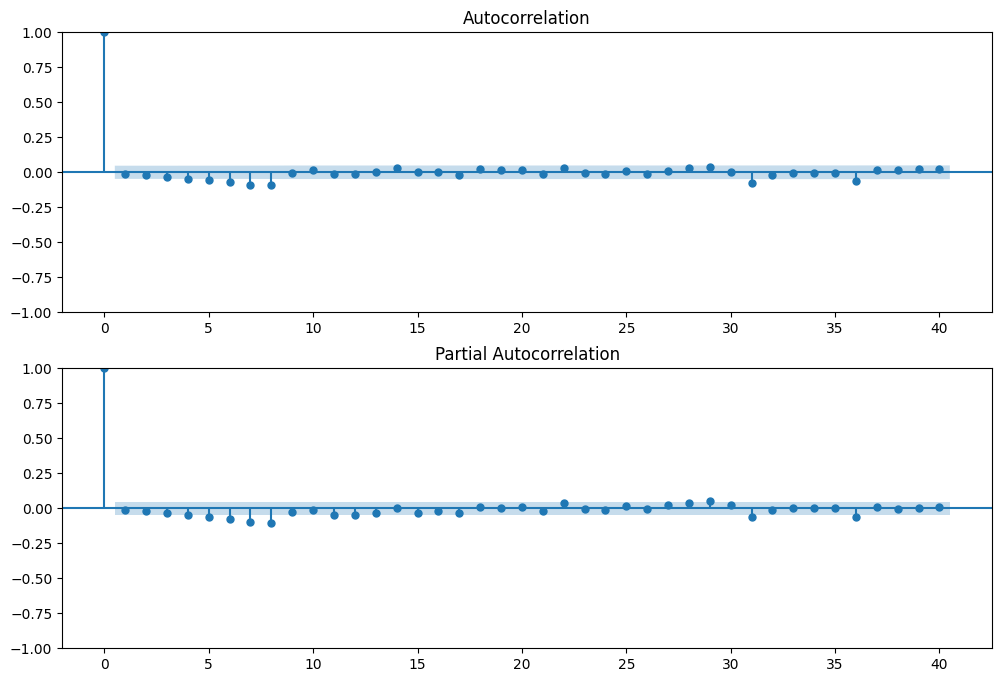

In [ ]:
# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sarima_mod7.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sarima_mod7.resid, lags=40, ax=ax2)

Residuals correlated

In [ ]:
model2 = pd.DataFrame(data = [[sarima_mod7.aic,mse2,mape2,smape2,'Fail']],
                     columns = model_eval.columns,
                     index = ['(7,1,0)(0,1,1)[7]'])
model_eval = model_eval.append(model2)
model_eval

,AIC,MSE,MAPE,MAPE,Residual Test
"(3,1,1)(1,0,1)[7]",10335.1,5.14%,26.69%,22.42%,Pass
"(7,1,0)(0,1,1)[7]",10328.644781,7.17%,39.96%,28.53%,Fail


## Method 3: grid search find p,d,q

In [ ]:
import itertools

p = range(2,5)
d = range(1,2)
q = range(0,2)
sp = sd = sq = range(0,2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(sp, sd, sq))
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[0]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[2]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (2, 1, 1) x (0, 0, 0)
SARIMAX: (2, 1, 1) x (0, 0, 1)
SARIMAX: (3, 1, 0) x (0, 1, 0)


In [ ]:
start_index = '2017-10-01'
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_1.sales[:start_index],order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False,
                                            freq='D')

            results = mod.fit()
            print('ARIMA{}x{}7 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue


In [ ]:
train_1 = train[(train['store']==1)&(train['item']==1)]
train_1 = train_1.set_index('date')
start_index = '2017-10-01'
end_index = '2017-12-31'
end_index1 = '2017-12-30'

sarima_mod7 = sm.tsa.statespace.SARIMAX(endog = train_1.sales[:start_index],
                                         order=(7,1,0),
                                         seasonal_order=(0,1,1,7),
                                         freq='D').fit()

train_1['forecast'] = sarima_mod7.predict(start = pd.to_datetime(start_index),
                                           end= pd.to_datetime(end_index),
                                           dynamic= True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



## SARIMAX: adding external variables

### c.SARIMAX external variables: month, day of week

From the EDA results, yearly pattern will be taken into account in the seasonality parameters, weekly effect and monthly effect will be put as external variables.

In [ ]:
train['year'] = train['date'].dt.year - 2012
train['month'] = train['date'].dt.month
train['weekday'] = train['date'].dt.weekday

train = pd.get_dummies(train, columns = ['year','month','weekday'] , prefix = ['year','month','weekday'])

In [ ]:
train.head()

,date,store,item,sales,year_1,year_2,year_3,year_4,year_5,month_1,...,month_10,month_11,month_12,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,2013-01-01,1,1,13,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
1,2013-01-02,1,1,11,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,2013-01-03,1,1,14,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,2013-01-04,1,1,13,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,2013-01-05,1,1,10,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
train_1 = train[(train['store']==1)&(train['item']==1)]

In [ ]:
train_1.head()

,date,store,item,sales,year_1,year_2,year_3,year_4,year_5,month_1,...,month_10,month_11,month_12,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,2013-01-01,1,1,13,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
1,2013-01-02,1,1,11,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,2013-01-03,1,1,14,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,2013-01-04,1,1,13,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,2013-01-05,1,1,10,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
ext_var_list = [ 'date', 'year_1','year_2','year_3','year_4','year_5',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6']

exog_data = train_1[ext_var_list]
exog_data.head()

,date,year_1,year_2,year_3,year_4,year_5,month_1,month_2,month_3,month_4,...,month_10,month_11,month_12,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,2013-01-01,1,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,2013-01-02,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,2013-01-03,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,2013-01-04,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,2013-01-05,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
train_1 = train_1.set_index('date')
exog_data = exog_data.set_index('date')

In [ ]:
train_1.head()

,store,item,sales,year_1,year_2,year_3,year_4,year_5,month_1,month_2,...,month_10,month_11,month_12,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,1,13,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2013-01-02,1,1,11,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2013-01-03,1,1,14,1,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2013-01-04,1,1,13,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2013-01-05,1,1,10,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
exog_data.head()

,year_1,year_2,year_3,year_4,year_5,month_1,month_2,month_3,month_4,month_5,...,month_10,month_11,month_12,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2013-01-02,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2013-01-03,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2013-01-04,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2013-01-05,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
start_index = '2017-10-01'
end_index = '2017-12-31'
end_index1 = '2017-12-30'#predict 90 days

In [ ]:
sarimax_mod7 = sm.tsa.statespace.SARIMAX(endog = train_1.sales[:start_index],
                                         exog = exog_data[:start_index],
                                         order=(7,1,0),
                                         seasonal_order=(0,1,1,7),
                                         freq='D').fit()
sarimax_mod7.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               sales   No. Observations:                 1735
Model:             SARIMAX(7, 1, 0)x(0, 1, [1], 7)   Log Likelihood               -5126.123
Date:                             Sun, 17 Sep 2023   AIC                          10318.247
Time:                                     14:18:47   BIC                          10498.234
Sample:                                 01-01-2013   HQIC                         10384.826
                                      - 10-01-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year_1         0.4238    3.3e+04   1.28e-05      1.000   -6.47e+04    6.47e+04
year_2        -0.0984    3.3e+04  -2.98e-06      1.000   -6.47e+04    6.47e+04
year_3         0.1940    3.3e+04   5.88e-06      1.000   -6.47e+04    6.47e+04
year_4         0.3642    3.3e+04    1.1e-05      1.000   -6.47e+04    6.47e+04
year_5        -0.9120    3.3e+04  -2.76e-05      1.000   -6.47e+04    6.47e+04
month_1       -4.4798   1.36e+04     -0.000      1.000   -2.67e+04    2.67e+04
month_2       -2.8298   1.36e+04     -0.000      1.000   -2.67e+04    2.67e+04
month_3       -1.1175   1.36e+04   -8.2e-05      1.000   -2.67e+04    2.67e+04
month_4        2.6148   1.36e+04      0.000      1.000   -2.67e+04    2.67e+04
month_5        1.6987   1.36e+04      0.000      1.000   -2.67e+04    2.67e+04
month_6        2.8723   1.36e+04      0.000      1.000   -2.67e+04    2.67e+04
month_7        2.3688   1.36e+04      0.000      1.000   -2.67e+04    2.67e+04
month_8       -0.7190   1.36e+04  -5.28e-05      1.000   -2.67e+04    2.67e+04
month_9        0.3530   1.36e+04   2.59e-05      1.000   -2.67e+04    2.67e+04
month_10      -0.0415   1.36e+04  -3.04e-06      1.000   -2.67e+04    2.67e+04
month_11       3.1732   1.36e+04      0.000      1.000   -2.67e+04    2.67e+04
month_12      -3.8825   1.36e+04     -0.000      1.000   -2.67e+04    2.67e+04
weekday_0  -5.303e-05   1.16e+05  -4.55e-10      1.000   -2.28e+05    2.28e+05
weekday_1   1.087e-06   1.44e+05   7.53e-12      1.000   -2.83e+05    2.83e+05
weekday_2   1.915e-05   1.18e+05   1.63e-10      1.000   -2.31e+05    2.31e+05
weekday_3  -1.495e-05   1.41e+05  -1.06e-10      1.000   -2.76e+05    2.76e+05
weekday_4   -8.04e-06   1.59e+05  -5.04e-11      1.000   -3.12e+05    3.12e+05
weekday_5   1.978e-05   1.11e+05   1.78e-10      1.000   -2.17e+05    2.17e+05
weekday_6   1.486e-05   2.25e+05    6.6e-11      1.000   -4.42e+05    4.42e+05
ar.L1         -0.8712      0.024    -36.768      0.000      -0.918      -0.825
ar.L2         -0.7846      0.031    -25.340      0.000      -0.845      -0.724
ar.L3         -0.6720      0.036    -18.768      0.000      -0.742      -0.602
ar.L4         -0.5413      0.038    -14.427      0.000      -0.615      -0.468
ar.L5         -0.3901      0.037    -10.588      0.000      -0.462      -0.318
ar.L6         -0.2643      0.032     -8.272      0.000      -0.327      -0.202
ar.L7         -0.1009      0.023     -4.301      0.000      -0.147      -0.055
ma.S.L7       -0.9991      0.048    -20.881      0.000      -1.093      -0.905
sigma2        21.5114      1.148     18.740      0.000      19.262      23.761
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                38.52
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):     

In [ ]:
sarimax_mod3 = sm.tsa.statespace.SARIMAX(endog = train_1.sales[:start_index],
                                         exog = exog_data[:start_index],
                                         order=(3,1,1),
                                         seasonal_order=(1,0,1,7),
                                         freq='D').fit()
sarimax_mod3.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             sales   No. Observations:                 1735
Model:             SARIMAX(3, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -5040.576
Date:                           Sun, 17 Sep 2023   AIC                          10143.153
Time:                                   14:19:34   BIC                          10312.356
Sample:                               01-01-2013   HQIC                         10205.730
                                    - 10-01-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
year_1        -0.5188      3.924     -0.132      0.895      -8.209       7.172
year_2         0.7717      3.033      0.254      0.799      -5.172       6.715
year_3         0.5834      2.250      0.259      0.795      -3.826       4.993
year_4        -0.1458      1.465     -0.099      0.921      -3.017       2.726
year_5        -0.6927      1.588     -0.436      0.663      -3.806       2.420
month_1       -5.8847      0.901     -6.530      0.000      -7.651      -4.118
month_2       -4.9939      0.825     -6.051      0.000      -6.611      -3.376
month_3       -1.9505      0.732     -2.666      0.008      -3.384      -0.517
month_4        1.5796      0.660      2.392      0.017       0.286       2.874
month_5        2.5649      0.627      4.092      0.000       1.336       3.794
month_6        5.0493      0.610      8.275      0.000       3.853       6.245
month_7        5.5417      0.607      9.130      0.000       4.352       6.731
month_8        2.1747      0.583      3.732      0.000       1.033       3.317
month_9        0.8646      0.557      1.553      0.120      -0.226       1.955
month_10      -0.4909      0.543     -0.904      0.366      -1.556       0.574
month_11       1.7258      0.544      3.172      0.002       0.659       2.792
month_12      -6.2186      0.554    -11.224      0.000      -7.305      -5.133
weekday_0     -4.3595      0.547     -7.976      0.000      -5.431      -3.288
weekday_1     -2.0272      0.590     -3.437      0.001      -3.183      -0.871
weekday_2     -1.0945      0.541     -2.022      0.043      -2.156      -0.033
weekday_3     -0.6504      0.542     -1.200      0.230      -1.713       0.412
weekday_4      1.2717      0.525      2.422      0.015       0.242       2.301
weekday_5      3.0127      0.524      5.746      0.000       1.985       4.040
weekday_6      3.8464      0.531      7.238      0.000       2.805       4.888
ar.L1         -0.0055      0.026     -0.212      0.832      -0.056       0.045
ar.L2         -0.0401      0.027     -1.506      0.132      -0.092       0.012
ar.L3         -0.0243      0.025     -0.966      0.334      -0.074       0.025
ma.L1         -0.9776      0.008   -126.821      0.000      -0.993      -0.963
ar.S.L7        0.9836      0.017     59.037      0.000       0.951       1.016
ma.S.L7       -0.9947      0.017    -57.214      0.000      -1.029      -0.961
sigma2        19.7944      0.674     29.354      0.000      18.473      21.116
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                28.66
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.31   Skew:                             0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.41
====================================

In [ ]:
train_1['forecast_7'] = sarimax_mod7.predict(start = pd.to_datetime(start_index),
                                           end= pd.to_datetime(end_index),
                                           exog = exog_data[start_index:end_index1],
                                           dynamic= True)
train_1['forecast_3'] = sarimax_mod3.predict(start = pd.to_datetime(start_index),
                                           end= pd.to_datetime(end_index),
                                           exog = exog_data[start_index:end_index1],
                                           dynamic= True)

<Axes: xlabel='date'>

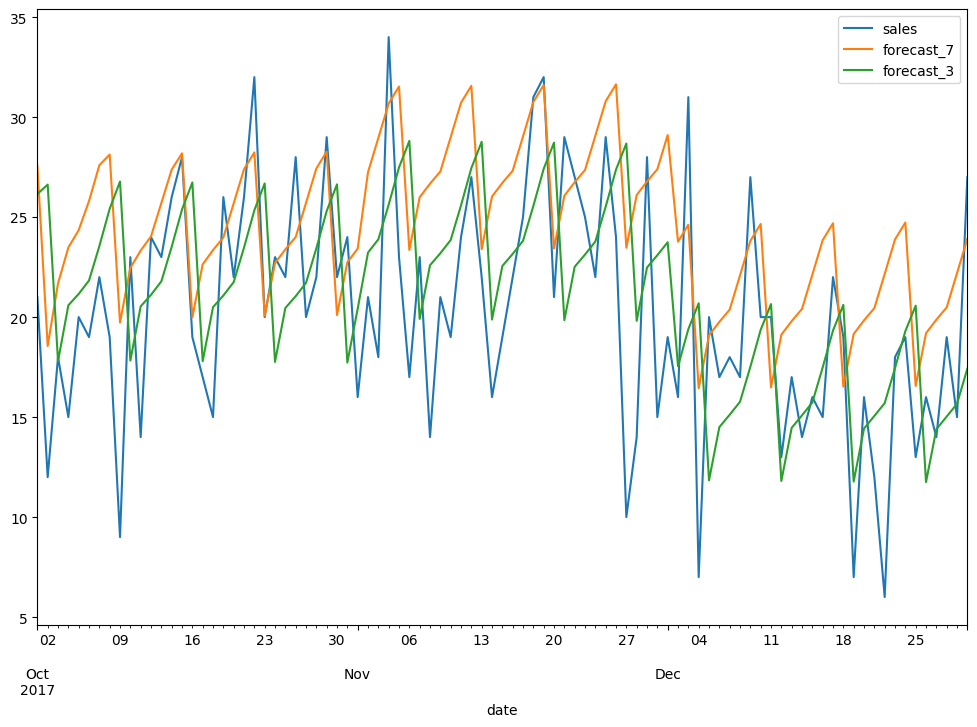

In [ ]:
train_1[start_index:end_index1][['sales', 'forecast_7','forecast_3']].plot(figsize=(12, 8))

In [ ]:
#calculate mse, mape, smape
mse7 = "{:.2%}".format(sqrt(mean_squared_error(train_1[start_index:end_index]['sales'],
                                                             train_1[start_index:end_index]['forecast_7']))/100)
y_true = train_1[start_index:end_index1]['sales']
y_pred = train_1[start_index:end_index1]['forecast_7']

mape7 ="{:.2%}".format(np.mean(abs((y_true-y_pred)/y_true)))
smape7 = "{:.2%}".format(np.mean((np.abs(y_pred - y_true) * 2/ (np.abs(y_pred) + np.abs(y_true))).fillna(0)))
print('SARIMAX (7,1,0)(0,1,1,7) \nAIC: %.2f'% (sarimax_mod7.aic), '\nMSE: ',mse7,'\nMAPE: ',mape7, '\nSMAPE: ', smape7)

SARIMAX (7,1,0)(0,1,1,7) 
AIC: 10318.25 
MSE:  6.25% 
MAPE:  34.12% 
SMAPE:  25.73%


In [ ]:
#calculate mse, mape, smape
mse3 = "{:.2%}".format(sqrt(mean_squared_error(train_1[start_index:end_index]['sales'],
                                                             train_1[start_index:end_index]['forecast_3']))/100)
y_true = train_1[start_index:end_index1]['sales']
y_pred = train_1[start_index:end_index1]['forecast_3']

mape3 ="{:.2%}".format(np.mean(abs((y_true-y_pred)/y_true)))
smape3 = "{:.2%}".format(np.mean((np.abs(y_pred - y_true) * 2/ (np.abs(y_pred) + np.abs(y_true))).fillna(0)))
print('SARIMAX (7,1,0)(0,1,1,7) \nAIC: %.2f'% (sarimax_mod7.aic), '\nMSE: ',mse3,'\nMAPE: ',mape3, '\nSMAPE: ', smape3)

SARIMAX (7,1,0)(0,1,1,7) 
AIC: 10318.25 
MSE:  5.88% 
MAPE:  28.24% 
SMAPE:  22.96%


NormaltestResult(statistic=32.64261725906969, pvalue=8.161044101595283e-08)


Text(0.5, 1.0, 'Residual distribution')

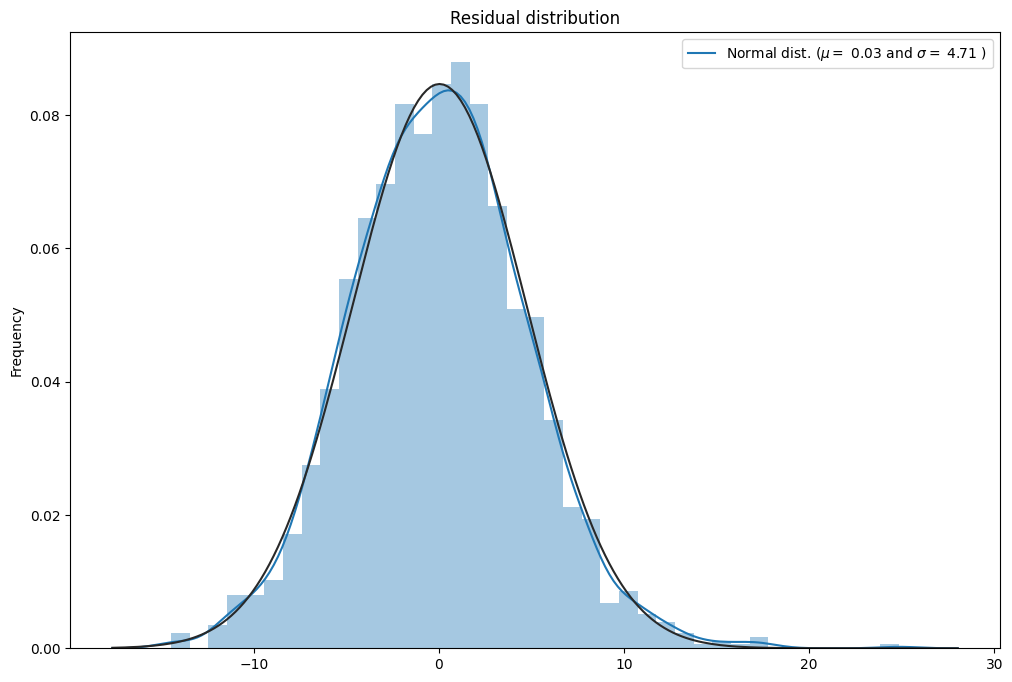

In [ ]:
from scipy import stats
from scipy.stats import normaltest

resid = sarimax_mod7.resid
print(normaltest(resid))

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0)
(mu, sigma) = stats.norm.fit(resid)

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')

NormaltestResult(statistic=40.20190107918175, pvalue=1.863236999359842e-09)


Text(0.5, 1.0, 'Residual distribution')

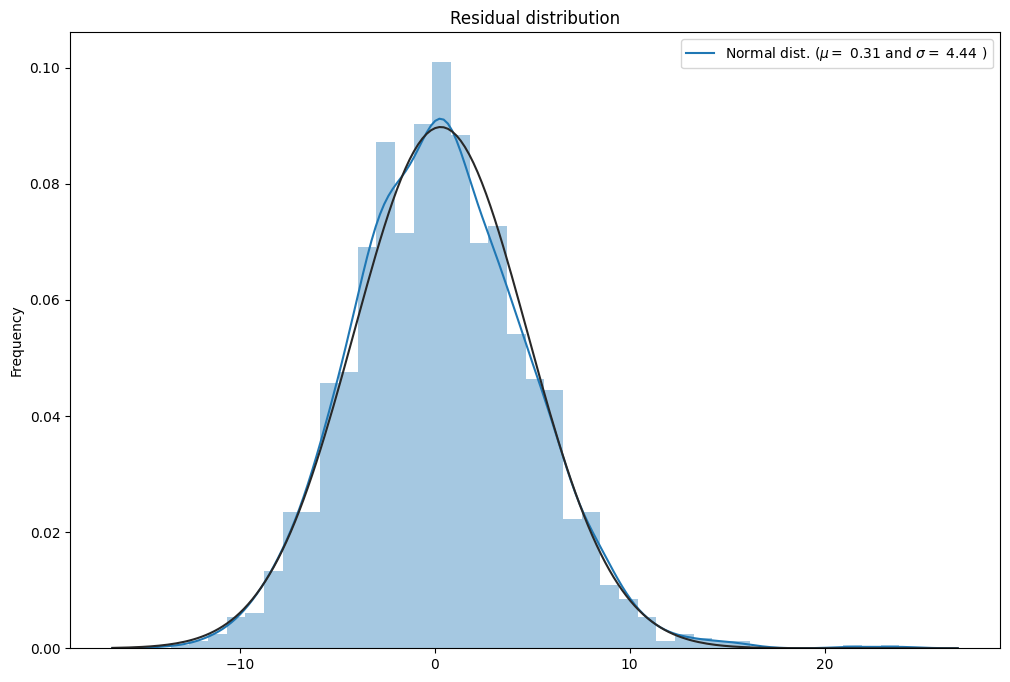

In [ ]:
resid = sarimax_mod3.resid
print(normaltest(resid))

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0)
(mu, sigma) = stats.norm.fit(resid)

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')

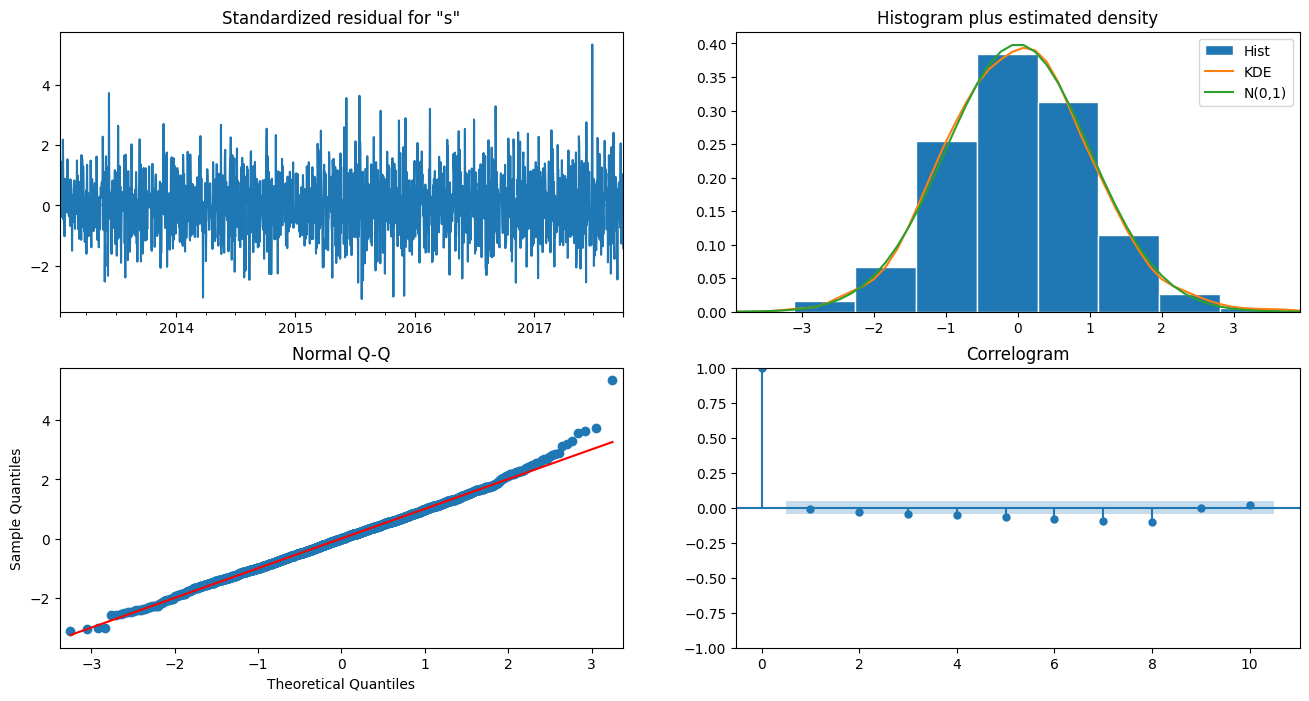

In [ ]:
sarimax_mod7.plot_diagnostics(figsize=(16, 8))
plt.show()

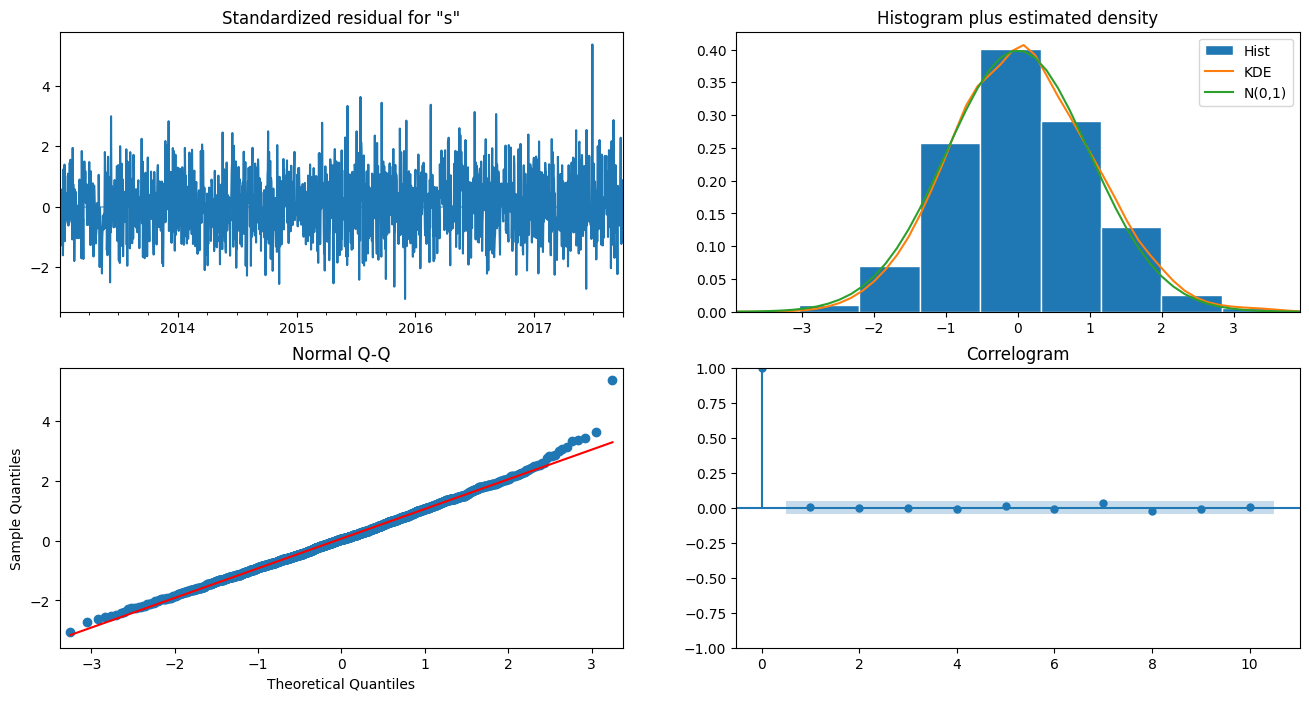

In [ ]:
sarimax_mod3.plot_diagnostics(figsize=(16, 8))
plt.show()

## Prediction on test dataset

In [ ]:
sample = pd.read_csv('sample_submission.csv')
train = pd.read_csv('train.csv', parse_dates=['date'], index_col='date')
test = pd.read_csv('test.csv', parse_dates=['date'], index_col='date')

In [ ]:
df = pd.concat([train,test],sort=True)

In [ ]:
#month one hot encoding
df['year'] = df.index.year - 2012
df['month'] = df.index.month
df['dayofweek'] = df.index.weekday
df = pd.get_dummies(df, columns = ['year','month','dayofweek'],prefix = ['year','month','dayofweek'])

In [ ]:
df.head()

,id,item,sales,store,year_1,year_2,year_3,year_4,year_5,year_6,...,month_10,month_11,month_12,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,NaN,1,13.0,1,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2013-01-02,NaN,1,11.0,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2013-01-03,NaN,1,14.0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2013-01-04,NaN,1,13.0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2013-01-05,NaN,1,10.0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
results = []
tr_start,tr_end = '2013-01-01','2017-09-30'
te_start,te_end = '2017-10-01','2017-12-31'
for i in range(1,51):
    for s in range(1,11):
        cur_df = df[(df.item==i)&(df.store==s)].copy()

        #train_test_split
        tra = cur_df['sales'][tr_start:tr_end]
        tes = cur_df['sales'][te_start:te_end]
        exog_train = cur_df.drop(['id','store','item','sales'],axis = 1)[tr_start:tr_end]
        exog_test = cur_df[te_start:].drop(['id','store','item','sales'],axis = 1)#exog for predict.


        #fitting
        mod = sm.tsa.statespace.SARIMAX(tra,order=(3,1,1),seasonal_order=(1,0,1,7),exog = exog_train,freq='D',
                                       enforce_stationarity=False, enforce_invertibility=False).fit()
        pred = mod.get_prediction(tr_end,'2018-03-31',exog =exog_test)#pd.concat([exog_test,target_exog]))
        results.extend(pred.predicted_mean['2018-01-01':])
        print('item:',i,'store:',s,'Finished.')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 1 store: 1 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 1 store: 2 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 1 store: 3 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 1 store: 4 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 1 store: 5 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 1 store: 6 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 1 store: 7 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 1 store: 8 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 1 store: 9 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 1 store: 10 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 2 store: 1 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 2 store: 2 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 2 store: 3 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 2 store: 4 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 2 store: 5 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 2 store: 6 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 2 store: 7 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 2 store: 8 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 2 store: 9 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 2 store: 10 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 3 store: 1 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 3 store: 2 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 3 store: 3 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 3 store: 4 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 3 store: 5 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 3 store: 6 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 3 store: 7 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 3 store: 8 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 3 store: 9 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 3 store: 10 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 4 store: 1 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 4 store: 2 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 4 store: 3 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 4 store: 4 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 4 store: 5 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 4 store: 6 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 4 store: 7 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 4 store: 8 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 4 store: 9 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 4 store: 10 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 5 store: 1 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 5 store: 2 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 5 store: 3 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 5 store: 4 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 5 store: 5 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 5 store: 6 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 5 store: 7 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 5 store: 8 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 5 store: 9 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 5 store: 10 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 6 store: 1 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 6 store: 2 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 6 store: 3 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 6 store: 4 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 6 store: 5 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 6 store: 6 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 6 store: 7 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 6 store: 8 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 6 store: 9 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 6 store: 10 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 7 store: 1 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 7 store: 2 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 7 store: 3 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 7 store: 4 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 7 store: 5 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



item: 7 store: 6 Finished.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



In [ ]:
results

In [ ]:
sample['sales'] = results

In [ ]:
#sample.to_csv('submission.csv',index=False)